In [161]:
# alpha:finish consulting; beta:new coming;
# overall timer format: (timepoint, event, station id, server id)

class Station:
    def __init__(self, stationid, overall_timer, process_param, n_server=0, n_buffer=0):
        self.stationid = stationid
        self.overall_timer = overall_timer
        self.s = n_server
        self.c = n_buffer
        self.wait = False
        self.status = [0, [0]*n_server] # 1 for occupied
        self.process_param = process_param
        self.next_station = None
    
    def setnext(self, next_station):
        self.next_station = next_station
        
    def printout(self):
        # print("time:{:.04f}".format(self.overall_timer[0][0]), " \tstation "+str(self.stationid)+":", self.status)
        return 0
    
    def update(self, timeslot):
        event= timeslot[1]
        if event == 'alpha':
            serverid = timeslot[3]
            self.alpha(serverid, timeslot)
        else:
            self.beta(timeslot)
        del(self.overall_timer[0])
        self.overall_timer.sort(key= lambda k:(k[0], int(-k[2])))
        
    def alpha(self, serverid, timeslot):
        if self.next_station == None:
            if self.status[0] > 0: # wqiting line is not empty
                self.status[0] -= 1
                try:
                    self.overall_timer.append((timeslot[0]+np.random.exponential(self.process_param), 'alpha', self.stationid, serverid))
                    self.printout()
                except:
                    print("empty process time list for station", self.stationid, "server", serverid)
            else:
                self.status[1][serverid] = 0
                self.printout()
                return True
        else:
            if self.next_station.beta(timeslot):
                if self.status[0] > 0: # waiting line is not empty
                    self.status[0] -= 1
                    try:
                        self.overall_timer.append((self.overall_timer[0][0]+np.random.exponential(self.process_param), 'alpha', self.stationid, serverid))
                        # del(self.process_times[0])
                        self.printout()
                    except:
                        print("empty process time list for station", self.stationid, "server", serverid)
                else:
                    self.status[1][serverid] = 0
                    self.printout()
                    return True
            else:
                for i in range(len(self.overall_timer)):
                    if self.overall_timer[i][2]==self.stationid+1:
                        self.overall_timer.append((self.overall_timer[i][0], 'alpha', self.stationid, serverid))
                        self.overall_timer.sort(key= lambda k:(k[0], int(-k[2])))
                        return True
                self.overall_timer.append((self.overall_timer[0][0], 'alpha', self.stationid, serverid))
                self.overall_timer.sort(key= lambda k:(k[0], int(-k[2])))
            
    def beta(self, timeslot=None):
        if self.status[0] > 0: 
            if self.status[0]<self.c:
                self.status[0]+=1
                self.printout()
                return True
            else:
                return False
        else:
            i = 0
            while i < self.s:
                if self.status[1][i]==0:
                    self.status[1][i]=1
                    self.overall_timer.append((timeslot[0]+np.random.exponential(self.process_param), 'alpha', self.stationid, i))
                    # self.process_times.remove(self.process_times[0])
                    break
                else:
                    i += 1
            if i == self.s:
                self.status[0]+=1
            self.printout()
            return True
        

In [168]:
import numpy as np
class simulation:
    def run(n_customers):
        timer = []
        t = np.random.poisson(2.1, n_customers)
        for i in range(n_customers):
            timer.append((t[i], 'beta', 0))
        timer.sort(key= lambda k:k[0])
            
        stations = []
        stations.append(Station(stationid=0, overall_timer=timer, process_param=2.9, n_server=1, n_buffer=5))
        stations.append(Station(stationid=1, overall_timer=timer, process_param=2.2, n_server=1, n_buffer=6))
        stations.append(Station(stationid=2, overall_timer=timer, process_param=2.2, n_server=1, n_buffer=6))
        stations.append(Station(stationid=3, overall_timer=timer, process_param=2.8, n_server=1, n_buffer=3))
        stations[2].setnext(stations[3])
        stations[1].setnext(stations[2])
        stations[0].setnext(stations[1])
        
        tt = 0
        while len(timer)>0:
            # print(timer)
            tt = timer[0][0]
            stations[timer[0][2]].update(timer[0])
        return tt
            

In [169]:
simulation.run(n_customers=1)

16.459252211276986

In [170]:
import matplotlib.pyplot as plt
def conf_int_95(y):
    a = np.mean(y)
    b = np.sqrt(np.var(y, ddof=1))
    return (a-1.96*b, a+1.96*b)

(22.73013152112144, 53.61325906444577)


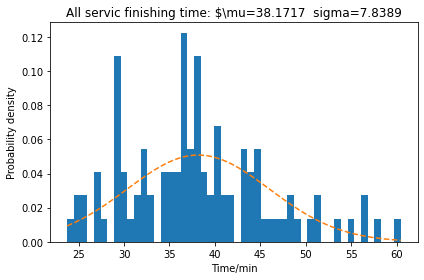

In [171]:
x0 = []
for i in range(100):
    x0.append(simulation.run(n_customers=10))
x = np.array(x0)
print(conf_int_95(x))

num_bins =  50
mu, sigma = np.mean(x), np.std(x)
fig, ax = plt.subplots()
ax.set_title('All servic finishing time: $\mu='+str(round(mu, 4))+'  sigma='+str(round(sigma, 4)))
ax.set_xlabel('Time/min')
ax.set_ylabel('Probability density')

n, bins, patches = ax.hist(x, num_bins, density=True)

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')

fig.tight_layout()
plt.show()

(21.58126571293168, 54.84462438035028)


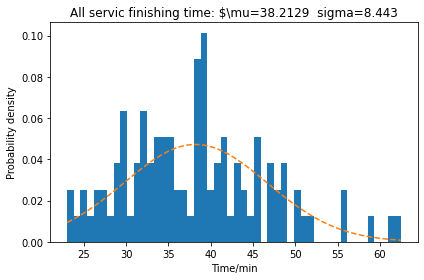

In [173]:
x0 = []
for i in range(100):
    for _ in range(100):
        x1 = []
        x1.append(simulation.run(n_customers=10))
    x0.append(np.mean(x1))
x = np.array(x0)
print(conf_int_95(x))

num_bins = 50
mu, sigma = np.mean(x), np.std(x)
fig, ax = plt.subplots()
ax.set_title('All servic finishing time: $\mu='+str(round(mu, 4))+'  sigma='+str(round(sigma, 4)))
ax.set_xlabel('Time/min')
ax.set_ylabel('Probability density')

n, bins, patches = ax.hist(x, num_bins, density=True)

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')

fig.tight_layout()
plt.show()

In [174]:
class simulation1:
    def run(n_customers):
        timer = []
        t = np.random.poisson(2.1, n_customers)
        for i in range(n_customers):
            timer.append((t[i], 'beta', 0))
        timer.sort(key= lambda k:k[0])
            
        stations = []
        stations.append(Station(stationid=0, overall_timer=timer, process_param=2.9, n_server=1, n_buffer=5))
        stations.append(Station(stationid=1, overall_timer=timer, process_param=2.2, n_server=2, n_buffer=6))
        stations.append(Station(stationid=2, overall_timer=timer, process_param=2.2, n_server=3, n_buffer=6))
        stations.append(Station(stationid=3, overall_timer=timer, process_param=2.8, n_server=1, n_buffer=3))
        stations[2].setnext(stations[3])
        stations[1].setnext(stations[2])
        stations[0].setnext(stations[1])
        
        tt = 0
        while len(timer)>0:
            # print(timer)
            tt = timer[0][0]
            stations[timer[0][2]].update(timer[0])
        return tt
            

In [175]:
simulation1.run(n_customers=10)

26.2910715642005

(16.548604013241846, 55.00243892343707)


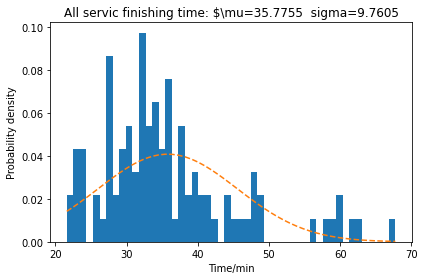

In [176]:
x0 = []
for i in range(100):
    x0.append(simulation1.run(n_customers=10))
x = np.array(x0)
print(conf_int_95(x))

num_bins =  50
mu, sigma = np.mean(x), np.std(x)
fig, ax = plt.subplots()
ax.set_title('All servic finishing time: $\mu='+str(round(mu, 4))+'  sigma='+str(round(sigma, 4)))
ax.set_xlabel('Time/min')
ax.set_ylabel('Probability density')

n, bins, patches = ax.hist(x, num_bins, density=True)

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')

fig.tight_layout()
plt.show()

(19.889999197141645, 52.273256126716774)


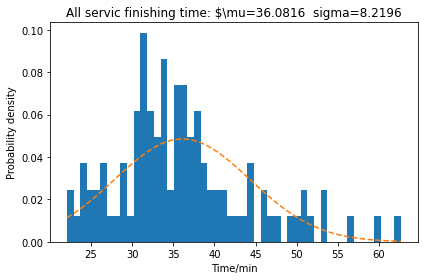

In [177]:
x0 = []
for i in range(100):
    for _ in range(100):
        x1 = []
        x1.append(simulation1.run(n_customers=10))
    x0.append(np.mean(x1))
x = np.array(x0)
print(conf_int_95(x))

num_bins = 50
mu, sigma = np.mean(x), np.std(x)
fig, ax = plt.subplots()
ax.set_title('All servic finishing time: $\mu='+str(round(mu, 4))+'  sigma='+str(round(sigma, 4)))
ax.set_xlabel('Time/min')
ax.set_ylabel('Probability density')

n, bins, patches = ax.hist(x, num_bins, density=True)

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')

fig.tight_layout()
plt.show()